In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
print("Running on GPU" if tf.test.is_gpu_available() else "Running on CPU")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Running on GPU


In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
else:
    print("Running on CPU")

Running on GPU


In [4]:
!pip install transformers diffusers accelerate segment-anything

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.5 MB/s eta 0:00:00


In [5]:
!pip install git+https://github.com/facebookresearch/segment-anything

  Cloning https://github.com/facebookresearch/segment-anything to /tmp/pip-req-build-op4w_slh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything /tmp/pip-req-build-op4w_slh
  Resolved https://github.com/facebookresearch/segment-anything to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [6]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-10-04 15:04:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   238MB/s    in 14s     

2024-10-04 15:04:22 (171 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [7]:
!ls

sample_data  sam_vit_h_4b8939.pth


In [8]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam_checkpoint = "sam_vit_h_4b8939.pth"
sam_model = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam = SamAutomaticMaskGenerator(model=sam_model)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
import os
os.environ['HUGGINGFACE_HUB_ALLOW_PICKLE'] = 'True'

Saving bagpack.jpg to bagpack (3).jpg


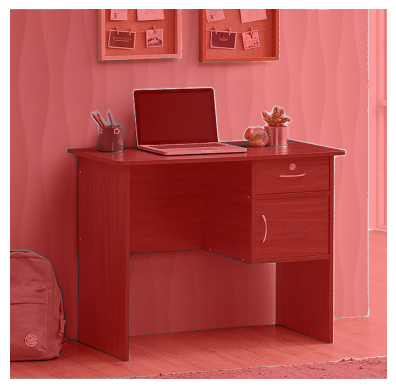

In [17]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

uploaded = files.upload()

input_image = Image.open("bagpack.jpg")

input_image_np = np.array(input_image)

sam_checkpoint = "sam_vit_h_4b8939.pth"
sam_model = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam = SamAutomaticMaskGenerator(model=sam_model)

masks = sam.generate(input_image_np)

mask_overlay = Image.new("RGBA", input_image.size)
for mask in masks:
    # Create a binary mask from the segmentation
    binary_mask = Image.fromarray(mask['segmentation'].astype(np.uint8) * 255)
    mask_overlay.paste((255, 0, 0, 100), (0, 0), binary_mask)  # Red mask with transparency

# Combine the original image and the mask overlay
output_image = Image.alpha_composite(input_image.convert("RGBA"), mask_overlay)
plt.imshow(output_image)
plt.axis('off')
plt.show()


In [18]:
def shift_object(image, mask, x_shift, y_shift):
    mask_array = np.array(mask['segmentation'])

    coords = np.column_stack(np.where(mask_array > 0))

    if len(coords) > 0:

        min_y, min_x = coords.min(axis=0)
        max_y, max_x = coords.max(axis=0)

        shifted_image = image.copy()

        object_region = image.crop((min_x, min_y, max_x, max_y))

        binary_mask = Image.fromarray(mask_array[min_y:max_y, min_x:max_x].astype(np.uint8) * 255)

        # Paste a blank (white) region on the original position to "erase" the object
        blank_region = Image.new("RGBA", (max_x - min_x, max_y - min_y), (255, 255, 255, 0))
        shifted_image.paste(blank_region, (min_x, min_y), binary_mask)

        new_min_x = min_x + x_shift
        new_min_y = min_y + y_shift

        shifted_image.paste(object_region, (new_min_x, new_min_y), binary_mask)

        return shifted_image

    return image


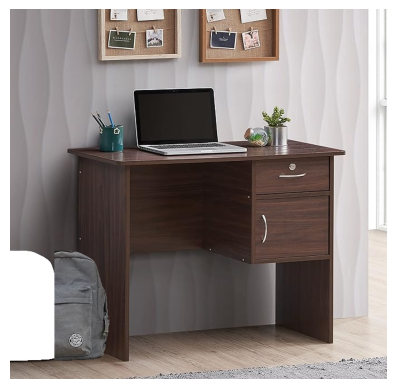

In [19]:

x_shift = 80  # Shift in x-direction
y_shift = 0   # Shift in y-direction

shifted_image = shift_object(input_image, masks[0], x_shift, y_shift)

plt.imshow(shifted_image)
plt.axis('off')
plt.show()
